In [8]:
import pandas as pd
import numpy as np
import os
import librosa
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial


def get_audio_duration(row, base_dir):
    """Calculate duration for a single audio file"""
    try:
        file_path = os.path.join(base_dir, row['utt_id'])
        duration = librosa.get_duration(path=file_path)
        return {
            'utt_id': row['utt_id'],
            'subset': row['subset'],
            'label': row['label'],
            'duration': duration
        }
    except Exception as e:
        print(f"Error processing {row['utt_id']}: {str(e)}")
        return {
            'utt_id': row['utt_id'],
            'subset': row['subset'],
            'label': row['label'],
            'duration': -1  # Mark failed files with -1
        }


def process_chunk(chunk, base_dir):
    """Process a chunk of the dataframe"""
    return [get_audio_duration(row, base_dir) for row in chunk.to_dict('records')]


def calculate_durations(protocol_file, base_dir, output_file, n_workers=None):
    """
    Calculate durations for all audio files in parallel
    
    Args:
        protocol_file: Path to protocol file
        base_dir: Base directory containing audio files
        output_file: Path to output CSV file
        n_workers: Number of worker processes (default: CPU count - 1)
    """
    if n_workers is None:
        n_workers = cpu_count() - 1

    print("Reading protocol file...")
    protocol = pd.read_csv(protocol_file, sep=" ", header=None)
    protocol.columns = ["utt_id", "subset", "label"]

    # Split dataframe into chunks for parallel processing
    chunk_size = len(protocol) // n_workers + 1
    chunks = np.array_split(protocol, n_workers)

    print(f"Processing {len(protocol)} files using {n_workers} workers...")

    # Process chunks in parallel
    with Pool(n_workers) as pool:
        partial_process = partial(process_chunk, base_dir=base_dir)
        results = list(tqdm(
            pool.imap(partial_process, chunks),
            total=len(chunks),
            desc="Calculating durations"
        ))

    # Flatten results and convert to dataframe
    all_results = [item for sublist in results for item in sublist]
    df_results = pd.DataFrame(all_results)

    # Calculate statistics
    valid_durations = df_results[df_results['duration'] != -1]['duration']
    stats = {
        'total_files': len(df_results),
        'failed_files': len(df_results[df_results['duration'] == -1]),
        'total_duration_hours': valid_durations.sum() / 3600,
        'mean_duration': valid_durations.mean(),
        'min_duration': valid_durations.min(),
        'max_duration': valid_durations.max()
    }

    # Save results
    print("\nSaving results...")
    df_results.to_csv(output_file, index=False)

    # Print statistics
    print("\nProcessing Statistics:")
    print(f"Total files processed: {stats['total_files']}")
    print(f"Failed files: {stats['failed_files']}")
    print(f"Total duration: {stats['total_duration_hours']:.2f} hours")
    print(f"Mean duration: {stats['mean_duration']:.2f} seconds")
    print(f"Min duration: {stats['min_duration']:.2f} seconds")
    print(f"Max duration: {stats['max_duration']:.2f} seconds")

    return df_results, stats


# Usage
BASE_DIR = "/data/hungdx/Lightning-hydra/data/0_large-corpus"
protocol_file = "new_protocol_trim_vocoded_v2.txt"
output_file = "audio_durations_v2.csv"

# Run the processing
df_results, stats = calculate_durations(
    protocol_file=protocol_file,
    base_dir=BASE_DIR,
    output_file=output_file,
    n_workers=8  # Adjust based on your system
)

# Display first few rows of results
print("\nFirst few rows of results:")
print(df_results.head())

Reading protocol file...
Processing 248159 files using 8 workers...


/home/hungdx/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Calculating durations: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]



Saving results...

Processing Statistics:
Total files processed: 248159
Failed files: 0
Total duration: 433.71 hours
Mean duration: 6.29 seconds
Min duration: 0.08 seconds
Max duration: 26.20 seconds

First few rows of results:
                          utt_id subset     label  duration
0     SNS/2024/Zuckerberg_38.wav  train  bonafide       7.0
1     SNS/2024/Matt_damon_58.wav  train  bonafide       6.5
2  SNS/2024/Anne_Hathaway_83.wav  train  bonafide       6.5
3    SNS/2024/Zuckerberg_127.wav  train  bonafide       7.0
4        SNS/2024/Macron_193.wav  train  bonafide       7.0


In [9]:
# Filter audio files with duration less than 1 second with subset == train
short_files = df_results[df_results['duration'] < 1 & (df_results['subset'] == 'train')]
print("\nShort audio files (duration < 1 second):")
print(len(short_files))


Short audio files (duration < 1 second):
436


In [10]:
# remove all files with duration < 1 second and subset == train
df_results = df_results[~((df_results['duration'] < 1) & (df_results['subset'] == 'train'))]

# drop duration column and save
df_results.drop(columns=['duration'], inplace=True)
df_results.to_csv("new_protocol_trim_vocoded_cleaned_v2.txt", index=False, header=False, sep=" ")

In [4]:
import pandas as pd

df = pd.read_csv("new_protocol_trim_vocoded_cleaned.txt", sep=" ", header=None)
df.columns = ["utt_id", "subset", "label"]

print("Before removing vocoded files:", len(df))

df = df[~((df["utt_id"].str.startswith("vocoded")) & (df["subset"] == "dev"))]

print("After removing vocoded files:", len(df))

Before removing vocoded files: 405579
After removing vocoded files: 390512


# MLAAD

In [5]:
import pandas as pd

df = pd.read_csv("~/MLAAD/protocol.txt", sep=" ", header=None)
df.columns = ["utt_id", "subset", "unk", "label"]

# drop unk column
df.drop(columns=['unk'], inplace=True)

df.to_csv("~/MLAAD/protocol_lts.txt", index=False, header=False, sep=" ")

In [4]:
import pandas as pd

df = pd.read_csv("new_protocol_trim_vocoded_cleaned.txt", sep=" ", header=None)
df.columns = ["utt_id", "subset", "label"]

print("Before removing vocoded files:", len(df))

df = df[~((df["utt_id"].str.startswith("vocoded")) & (df["subset"] == "dev"))]

print("After removing vocoded files:", len(df))

Before removing vocoded files: 405579
After removing vocoded files: 390512


# MLAAD V5

In [3]:
import os
import pandas as pd
from pathlib import Path
import csv


def read_csv_safely(file_path):
    try:
        # First attempt with standard reading
        return pd.read_csv(file_path, sep='|')
    except:
        try:
            # Second attempt with quote character handling
            return pd.read_csv(file_path, sep='|', quoting=csv.QUOTE_NONE, escapechar='\\')
        except:
            try:
                # Third attempt with error handling
                return pd.read_csv(file_path, sep='|', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
            except Exception as e:
                print(f"Error reading file {file_path}: {str(e)}")
                return None


def create_protocol_and_merge_meta(root_dir):
    # Initialize empty list to store all metadata
    all_meta_data = []

    # Initialize protocol file
    protocol_lines = []

    # Walk through the directory structure
    for language_dir in os.listdir(root_dir):
        language_path = os.path.join(root_dir, language_dir)
        if not os.path.isdir(language_path):
            continue

        # For each model directory in the language directory
        for model_dir in os.listdir(language_path):
            model_path = os.path.join(language_path, model_dir)
            if not os.path.isdir(model_path):
                continue

            # Look for meta.csv file
            meta_file = os.path.join(model_path, 'meta.csv')
            if os.path.exists(meta_file):
                # Read meta.csv with safe reading function
                df = read_csv_safely(meta_file)

                if df is not None:
                    # Add to combined metadata
                    all_meta_data.append(df)

                    # Create protocol lines for all audio files in this directory
                    for audio_path in df['path']:
                        protocol_lines.append(f"{audio_path} eval spoof")

    # Combine all metadata
    if all_meta_data:
        combined_meta = pd.concat(all_meta_data, ignore_index=True)

        # Save combined metadata
        combined_meta.to_csv('mlaad_v5_combined_meta.csv', sep='|',
                             index=False, quoting=csv.QUOTE_NONE, escapechar='\\')

        # Save protocol file
        with open('mlaad_v5_protocol.txt', 'w') as f:
            f.write('\n'.join(protocol_lines))

        print(f"Created protocol.txt with {len(protocol_lines)} entries")
        print(f"Created combined_meta.csv with {len(combined_meta)} entries")
    else:
        print("No meta.csv files found or all files had errors")


# Run the function
if __name__ == "__main__":
    create_protocol_and_merge_meta(
        '/nvme1/hungdx/Lightning-hydra/data/mlaad_v5/fake')

Created protocol.txt with 152388 entries
Created combined_meta.csv with 152388 entries


# partialSpoof protocol generator

In [4]:
import os
from pathlib import Path
from tqdm import tqdm


def read_protocol_metadata(protocol_file):
    """Read protocol metadata and create mapping dictionary."""
    metadata = {}
    with open(protocol_file, 'r') as f:
        lines = f.readlines()
        for line in tqdm(lines, desc=f"Reading {protocol_file.name}", leave=False):
            parts = line.strip().split()
            # print(parts)
            # import sys
            # sys.exit()
            if len(parts) >= 4:
                # Extract the file ID (e.g., LA_0079) from the first column
                file_id = parts[1]
                label = parts[4]    # spoof or bonafide
                metadata[file_id] = label
    return metadata


def create_new_protocol(lst_file, wav_folder, protocol_metadata, subset, output_file):
    """Create new protocol file with wav paths and labels."""
    with open(lst_file, 'r') as f:
        file_ids = [line.strip() for line in f.readlines()]

    missing_labels = []
    with open(output_file, 'w') as out_f:
        for file_id in tqdm(file_ids, desc=f"Processing {subset}", leave=False):
            wav_path = f"{subset}/con_wav/{file_id}.wav"
            # Direct dictionary lookup instead of loop
            label = protocol_metadata.get(file_id)

            if label:
                out_f.write(f"{wav_path} {subset} {label}\n")
            else:
                missing_labels.append(file_id)

    if missing_labels:
        print(
            f"\nWarning: No labels found for {len(missing_labels)} files in {subset}")
        print("First few missing files:", missing_labels[:5])


def main():
    # Define paths
    base_dir = Path("/nvme1/hungdx/Lightning-hydra/data/PartialSpoof/database")
    protocol_dir = base_dir / "protocols/PartialSpoof_LA_cm_protocols"

    # Process each subset (train, dev, eval)
    subsets = ['train', 'dev', 'eval']

    print("Starting protocol file creation...")
    for subset in tqdm(subsets, desc="Processing subsets"):
        # Input files
        protocol_file = protocol_dir / f"PartialSpoof.LA.cm.{subset}.trl.txt"
        lst_file = base_dir / subset / f"{subset}.lst"
        output_file = base_dir / f"protocol_{subset}.txt"

        # Read protocol metadata
        metadata = read_protocol_metadata(protocol_file)

        # Create new protocol file
        create_new_protocol(
            lst_file=lst_file,
            wav_folder=subset,
            protocol_metadata=metadata,
            subset=subset,
            output_file=output_file
        )

        print(f"✓ Created protocol file for {subset}: {output_file}")

    print("\nProtocol file creation completed!")

main()

Starting protocol file creation...


Processing subsets:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Created protocol file for train: /nvme1/hungdx/Lightning-hydra/data/PartialSpoof/database/protocol_train.txt


Processing subsets:  67%|██████▋   | 2/3 [00:00<00:00, 14.60it/s]

✓ Created protocol file for dev: /nvme1/hungdx/Lightning-hydra/data/PartialSpoof/database/protocol_dev.txt


Processing subsets: 100%|██████████| 3/3 [00:00<00:00, 11.17it/s]


First few missing files: ['CON_E_0034982', 'CON_E_0058039']
✓ Created protocol file for eval: /nvme1/hungdx/Lightning-hydra/data/PartialSpoof/database/protocol_eval.txt

Protocol file creation completed!


## Extend ASVspoof generator 

This dataset includes: Orginal ASVspoof dataset and my trimmed version of ASVspoof dataset.

In [16]:
import pandas as pd


# Prepare original train set
df_ori_train = pd.read_csv(
    "/nvme1/hungdx/Datasets/protocols/database/ASVspoof_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt", sep=" ", header=None)
df_ori_train.columns = ["unk1", "utt", "unk2", "attack", "label"]

df_ori_train["subset"] = "train"

# prepare trimmed train set

df_trimmed_train = pd.read_csv(
    "/nvme1/hungdx/Datasets/prototcols/LA19.cm.train.trn_1s.txt", sep=" ", header=None)
df_trimmed_train.columns = ["unk1", "utt", "unk2", "attack", "label"]

# add subset column
df_trimmed_train["subset"] = "train"


# Filter utt  without contain no_speech
df_trimmed_train = df_trimmed_train[~df_trimmed_train["utt"].str.contains("no_speech")]

# Prepare original dev set
df_ori_dev = pd.read_csv(
    "/nvme1/hungdx/Datasets/protocols/database/ASVspoof_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt", sep=" ", header=None)
df_ori_dev.columns = ["unk1", "utt", "unk2", "attack", "label"]

df_ori_dev["subset"] = "dev"

index_col = 'trial'
# =====
# Configuration to load CM protocol and score file
# =====
# name of data series for procotol file
p_names = ['speaker', index_col, 'compr', 'source', 'attack',
                'label', 'trim', 'subset', 'vocoder', 
                'task', 'team', 'gender-pair', 'language']


df_eval_trial = pd.read_csv(
    '/nvme1/hungdx/Datasets/protocols/database/ASVspoof_DF_cm_protocols/ASVspoof2021.DF.cm.eval.trl.txt', sep=" ", header=None)
df_eval_trial.columns = ['utt']

df_eval_meta = pd.read_csv(
    '/nvme1/hungdx/Lightning-hydra/logs/asvspoof-challenge-2021/eval-package/keys/DF/CM/trial_metadata.txt', sep=" ", header=None)

df_eval_meta.columns = p_names

# Merge trial and metadata

df_eval = pd.merge(df_eval_trial, df_eval_meta, left_on='utt', right_on=index_col)

# keep only utt and label
df_eval = df_eval[['utt', 'label']]

df_eval["subset"] = "eval"

TRAIN_PATH = "ASVspoof2019_LA_train/"
TRIMMED_TRAIN_PATH = "LA19_train_1s/"
DEV_PATH = "ASVspoof2019_LA_dev/"
EVAL_PATH = "ASVspoof2021_DF_eval/"


# Merge df_ori_train, df_trimmed_train, df_ori_dev, df_eval into a single dataframe
# Keep only utt, subset and label columns
# new utt should be the full path to the audio file
# For example, with subset = "train" and utt = "LA_T_1000001", the new utt should be f"{TRAIN_PATH}/LA_T_1000001.flac"

df_ori_train["utt"] = df_ori_train["utt"].apply(lambda x: f"{TRAIN_PATH}/{x}.flac")
df_trimmed_train["utt"] = df_trimmed_train["utt"].apply(lambda x: f"{TRIMMED_TRAIN_PATH}/{x}.flac")
df_ori_dev["utt"] = df_ori_dev["utt"].apply(lambda x: f"{DEV_PATH}/{x}.flac")
df_eval["utt"] = df_eval["utt"].apply(lambda x: f"{EVAL_PATH}/{x}.flac")


df = pd.concat([df_ori_train[["utt", "subset", "label"]], df_trimmed_train[["utt", "subset", "label"]], df_ori_dev[["utt", "subset", "label"]], df_eval[["utt", "subset", "label"]]], ignore_index=True)

df.to_csv("/nvme1/hungdx/Lightning-hydra/data/ExtendedASVspoof/protocol.txt",
          index=False, header=False, sep=" ")

# ADD track 2

In [4]:
import pandas as pd


label = pd.read_csv(
    "/nvme1/hungdx/Lightning-hydra/data/ADD_eval/track2_label.txt", sep=" ", header=None)
label.columns = ["utt", "label"]

# add subset column
label["subset"] = "eval"

# move subset column to second column
label = label[["utt", "subset", "label"]]

# Change value of label column (fake -> spoof, genuine -> bonafide)
label["label"] = label["label"].apply(lambda x: "spoof" if x == "fake" else "bonafide")

# save to file
label.to_csv("/nvme1/hungdx/Lightning-hydra/data/ADD_eval/protocol.txt",
             index=False, header=False, sep=" ")


# Noisy dataset (ASVSpoof_Laundered)

In [1]:
import pandas as pd

Filtering_df = pd.read_csv("/nvme1/Datasets/ASVSpoof_Laundered_protocols/ASVspoofLauneredDatabase_Filtering.txt", sep=" ", header=None)
Filtering_df.columns = ["LA_group", "utt", "attack", "label", "group", "subgroup"]

Noise_Addition_df = pd.read_csv("/nvme1/Datasets/ASVSpoof_Laundered_protocols/ASVspoofLauneredDatabase_Noise_Addition.txt", sep=" ", header=None)
Noise_Addition_df.columns = ["LA_group", "utt", "attack", "label", "group", "subgroup"]

Recompression_df = pd.read_csv("/nvme1/Datasets/ASVSpoof_Laundered_protocols/ASVspoofLauneredDatabase_Recompression.txt", sep=" ", header=None)
Recompression_df.columns = ["LA_group", "utt", "attack", "label", "group", "subgroup"]


Resampling_df = pd.read_csv("/nvme1/Datasets/ASVSpoof_Laundered_protocols/ASVspoofLauneredDatabase_Resampling.txt", sep=" ", header=None)
Resampling_df.columns = ["LA_group", "utt", "attack", "label", "group", "subgroup"]


Reverberation_df = pd.read_csv("/nvme1/Datasets/ASVSpoof_Laundered_protocols/ASVspoofLauneredDatabase_Reverberation.txt", sep=" ", header=None)
Reverberation_df.columns = ["LA_group", "utt", "attack", "label", "group", "subgroup"]

In [2]:
# Merge all dataframes

df = pd.concat([Filtering_df, Noise_Addition_df, Recompression_df, Resampling_df, Reverberation_df], ignore_index=True)
#df
# Create a protocol.txt file with utt, subset and label columns
# the subset column has two values: train and dev 
# The ratio of train and dev is 50:50




In [18]:


# Select only required columns: utt, label
df = df[['utt', 'label']].copy()

# Shuffle the dataset to ensure randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into 50% train, 50% dev
split_idx = len(df) // 2
df.loc[:split_idx, 'subset'] = 'train'
df.loc[split_idx:, 'subset'] = 'dev'

# Reorder columns as required
df = df[['utt', 'subset', 'label']]
df['utt'] = df['utt'].apply(lambda x: f"{x}.flac")
# Save to protocol.txt (tab-separated)
df.to_csv("protocol.txt", sep=' ', index=False, header=False)

print("protocol.txt file has been created successfully!")

protocol.txt file has been created successfully!


In [15]:
print(df['subset'].value_counts())


subset
dev      1032937
train    1032936
Name: count, dtype: int64


In [20]:
# Select only required columns: utt, label
df = df[['utt', 'label']].copy()

# Separate bonafide and spoof samples
df_bonafide = df[df['label'] == 'bonafide']
df_spoof = df[df['label'] == 'spoof']

# Ensure equal number of spoof and bonafide samples
num_bonafide = len(df_bonafide)
df_spoof_balanced = df_spoof.sample(n=num_bonafide, random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([df_bonafide, df_spoof_balanced])

# Shuffle the dataset for randomness
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into 50% train and 50% dev
split_idx = len(df_balanced) // 2
df_balanced.loc[:split_idx, 'subset'] = 'train'
df_balanced.loc[split_idx:, 'subset'] = 'dev'

# Reorder columns as required
df_balanced = df_balanced[['utt', 'subset', 'label']]

# Append ".flac" to utt column
df_balanced['utt'] = df_balanced['utt'].apply(lambda x: f"{x}.flac")

# Save to protocol.txt (space-separated, no header)
df_balanced.to_csv("balanced_protocol.txt", sep=' ', index=False, header=False)

print("✅ balanced_protocol.txt file has been created successfully with balanced classes!")

✅ balanced_protocol.txt file has been created successfully with balanced classes!


In [3]:
# Select only required columns: utt, label
df = df[['utt', 'label']].copy()

# Separate bonafide and spoof samples
df_bonafide = df[df['label'] == 'bonafide']
df_spoof = df[df['label'] == 'spoof']

# Ensure equal number of spoof and bonafide samples
num_bonafide = len(df_bonafide)
df_spoof_balanced = df_spoof.sample(n=num_bonafide, random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([df_bonafide, df_spoof_balanced])

# Shuffle the dataset for randomness
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into 50% train and 50% dev
split_idx = len(df_balanced) // 2
df_balanced.loc[:split_idx, 'subset'] = 'train'
df_balanced.loc[split_idx:, 'subset'] = 'dev'

# Reorder columns as required
df_balanced = df_balanced[['utt', 'subset', 'label']]

# Append ".flac" to utt column
df_balanced['utt'] = df_balanced['utt'].apply(lambda x: f"ASVSpoof_Laundered_flac/{x}.flac")

# Save to protocol.txt (space-separated, no header)
# df_balanced.to_csv("balanced_protocol.txt", sep=' ', index=False, header=False)

# print("✅ balanced_protocol.txt file has been created successfully with balanced classes!")

In [5]:
df_balanced.to_csv("new_balanced_protocol.txt", sep=' ', index=False, header=False)

In [ ]:
df_balanced

# Large corpus Nov Custom

## Pitch shift, time stretch

In [1]:
import pandas as pd
import sys

sys.path.append("../")



from src.data.components.augwrapper import pitch_v1, time_stretch_v1, autotune_v1

In [2]:
df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/notebooks/new_protocol_trim_vocoded_cleaned_v2.txt", sep=" ", header=None)
df.columns = ["utt", "subset", "label"]

df 

,utt,subset,label
0,SNS/2024/Zuckerberg_38.wav,train,bonafide
1,SNS/2024/Matt_damon_58.wav,train,bonafide
2,SNS/2024/Anne_Hathaway_83.wav,train,bonafide
3,SNS/2024/Zuckerberg_127.wav,train,bonafide
4,SNS/2024/Macron_193.wav,train,bonafide
...,...,...,...
247718,vocoded/waveglow/trump_40.wav,train,spoof
247719,vocoded/waveglow/trump_85.wav,train,spoof
247720,vocoded/waveglow/trump_86.wav,train,spoof
247721,vocoded/waveglow/wkorea_danielle_4.wav,train,spoof


In [ ]:
from IPython.display import Audio, display
import librosa.display
import matplotlib.pyplot as plt
import random
import numpy as np
import os


def play_and_show(file_path):
    """
    Play and show an audio file
    :param file_path: path to audio file
    """
    y, sr = librosa.load(file_path, sr=None)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    display(Audio(file_path, rate=16000))
    # Compute the spectrogram
    S = np.abs(librosa.stft(y, n_fft=2048, hop_length=240, win_length=480, window='hamming'))
    D = librosa.amplitude_to_db(S, ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', n_fft=2048, hop_length=240, win_length=480, 
                               sr=sr, ax=ax)
    plt.show()
    
BASE_DIR = "/nvme1/hungdx/Lightning-hydra/data/0_large-corpus"

# random get 1 sample
random_sample = df.sample(1)["utt"].values[0]
random_sample_path = os.path.join(BASE_DIR, random_sample)
# print(f"Playing and showing: {random_sample_path}")


# play_and_show(random_sample_path)


class Args:
    def __init__(self):
        self.aug_dir = "/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/aug
        self.online_aug = False
        self.noise_path = "/tmp/noise.wav"
        

args = Args()

# Apply autotune_v1 augmentation
autotune_sample = autotune_v1(random_sample_path, args, audio_path=random_sample_path)


: 

Playing and showing: /nvme1/hungdx/Lightning-hydra/data/0_large-corpus/Synthesizers/VITS_Korean/05FHEJ0048_Voice_data/05FHEJ0048_000192.wav


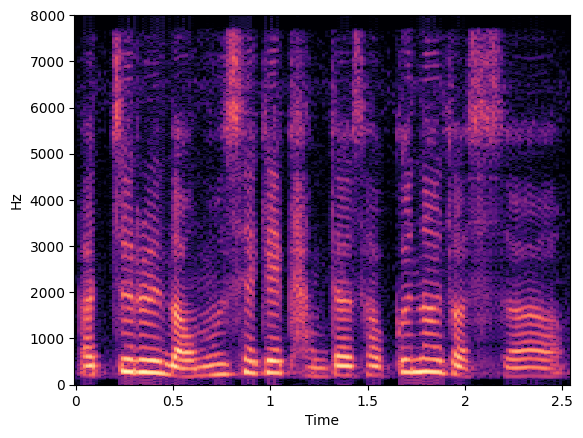

Playing and showing: /tmp/pitch


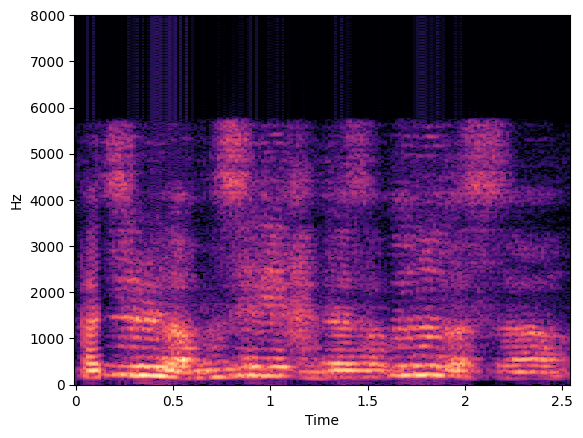

In [5]:
print(f"Playing and showing: {random_sample_path}")


play_and_show(random_sample_path)

print(f"Playing and showing: /tmp/pitch")
play_and_show("/tmp/pitch/05FHEJ0048_000192.wav")

# Prepare dataset for lora 

In [1]:
import pandas as pd
import os

In [2]:
large_corpus_df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/protocol.txt", sep=" ", header=None)
large_corpus_df.columns = ["utt", "subset", "label"]
large_corpus_df.head()

,utt,subset,label
0,SNS/2024/Zuckerberg_38.wav,train,bonafide
1,SNS/2024/Matt_damon_58.wav,train,bonafide
2,SNS/2024/Anne_Hathaway_83.wav,train,bonafide
3,SNS/2024/Zuckerberg_127.wav,train,bonafide
4,SNS/2024/Macron_193.wav,train,bonafide


In [3]:
# organize the data:
# 1. subset train: keep 5000 bonafide and 5000 spoof samples
df = large_corpus_df.copy()
df_train = df[df["subset"] == "train"]
df_train_bonafide = df_train[df_train["label"] == "bonafide"]
df_train_spoof = df_train[df_train["label"] == "spoof"]

# keep 5000 bonafide and 5000 spoof samples
df_train_bonafide = df_train_bonafide.sample(n=5000, random_state=42)
df_train_spoof = df_train_spoof.sample(n=5000, random_state=42)

# combine bonafide and spoof samples
df_train = pd.concat([df_train_bonafide, df_train_spoof])


# 2. subset dev: keep 5000 bonafide and 5000 spoof samples
df_dev = df[df["subset"] == "dev"]
df_dev_bonafide = df_dev[df_dev["label"] == "bonafide"]
df_dev_spoof = df_dev[df_dev["label"] == "spoof"]

# keep 5000 bonafide and 5000 spoof samples
df_dev_bonafide = df_dev_bonafide.sample(n=5000, random_state=42)
df_dev_spoof = df_dev_spoof.sample(n=5000, random_state=42)

# combine bonafide and spoof samples
df_dev = pd.concat([df_dev_bonafide, df_dev_spoof])

# 3. remove eval subset

# combine train and dev
df = pd.concat([df_train, df_dev])


## Pitch shift, time stretch

In [ ]:
asv19_pitch_time = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/shortcutASV/asv19/time_shift_pitch_shift.txt", sep=" ", header=None)
mlaad_pitch_time = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/shortcutASV/mlaad/time_stretch_pitch_shift.txt", sep=" ", header=None)

asv19_pitch_time.columns = ["utt", "subset", "label"]
mlaad_pitch_time.columns = ["utt", "subset", "label"]

# combine asv19_pitch_time and mlaad_pitch_time
combine_asv19_mlaad = pd.concat([asv19_pitch_time, mlaad_pitch_time])

# rigt now all subset are train, random split 50% train and 50% dev

# shuffle the dataset
combine_asv19_mlaad = combine_asv19_mlaad.sample(frac=1, random_state=42).reset_index(drop=True)

# split into 50% train and 50% dev
split_idx = len(combine_asv19_mlaad) // 2
combine_asv19_mlaad.loc[:split_idx, 'subset'] = 'train'
combine_asv19_mlaad.loc[split_idx:, 'subset'] = 'dev'

concat_df = pd.concat([df, combine_asv19_mlaad])

concat_df.to_csv("/nvme1/hungdx/Lightning-hydra/notebooks/protocols/protocl_for_pitch_time", sep=" ", index=False, header=False)



## gaussian noise

In [7]:
asv19_gaussian = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/shortcutASV/asv19/gaussian_noise.txt", sep=" ", header=None)
mlaad_gaussian = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/shortcutASV/mlaad/gaussian_noise.txt", sep=" ", header=None)


asv19_gaussian.columns = ["utt", "subset", "label"]
mlaad_gaussian.columns = ["utt", "subset", "label"]

# combine asv19_gaussian and mlaad_gaussian
combine_asv19_mlaad = pd.concat([asv19_gaussian, mlaad_gaussian])

# rigt now all subset are train, random split 50% train and 50% dev

# shuffle the dataset
combine_asv19_mlaad = combine_asv19_mlaad.sample(frac=1, random_state=42).reset_index(drop=True)

# split into 50% train and 50% dev
split_idx = len(combine_asv19_mlaad) // 2
combine_asv19_mlaad.loc[:split_idx, 'subset'] = 'train'
combine_asv19_mlaad.loc[split_idx:, 'subset'] = 'dev'

concat_df = pd.concat([df, combine_asv19_mlaad])

concat_df.to_csv("/nvme1/hungdx/Lightning-hydra/notebooks/protocols/protocl_for_gau", sep=" ", index=False, header=False)


## echo, autotune, amplitude modulation

In [8]:
asv19_echo_autotune_amp = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/shortcutASV/asv19/echo_autotune_amp.txt", sep=" ", header=None)
mlaad_echo_autotune_amp = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/shortcutASV/mlaad/echo_autotune_amp.txt", sep=" ", header=None)


asv19_echo_autotune_amp.columns = ["utt", "subset", "label"]
mlaad_echo_autotune_amp.columns = ["utt", "subset", "label"]

# combine asv19_echo_autotune_amp and mlaad_echo_autotune_amp
combine_asv19_mlaad = pd.concat([asv19_echo_autotune_amp, mlaad_echo_autotune_amp])

# rigt now all subset are train, random split 50% train and 50% dev

# shuffle the dataset
combine_asv19_mlaad = combine_asv19_mlaad.sample(frac=1, random_state=42).reset_index(drop=True)

# split into 50% train and 50% dev
split_idx = len(combine_asv19_mlaad) // 2
combine_asv19_mlaad.loc[:split_idx, 'subset'] = 'train'
combine_asv19_mlaad.loc[split_idx:, 'subset'] = 'dev'

concat_df = pd.concat([df, combine_asv19_mlaad])

concat_df.to_csv("/nvme1/hungdx/Lightning-hydra/notebooks/protocols/protocl_for_echo_autotune_amp.txt", sep=" ", index=False, header=False)


# Large corpus Nov Custom 
This version is include:
- Original Nov
- Vocoded samples
- librosa trimmed samples
- pitch shift samples
- More ElevenLabs samples
- More Koreans samples
- More telephony samples

In [2]:
import os


TELEPHONY_REAL_FOLDER_NAME = "2024_Telephone_Real"
TELEPHONY_FAKE_FOLDER_NAME = "2024_Telephone_Fake"
MORE_KOREAN_TTS_FOLDER_NAME = "More_Korean_TTS"
Oct2024_Elevenlabs_FOLDER_NAME = "202410_Elevenlabs"
Feb2025_Elevenlabs_FOLDER_NAME = "202502_Elevenlabs"
Elevenlabs_failed_detection_Dec_09_FOLDER_NAME = "Elevenlabs_failed_detection_Dec_09"
BASE_DIR = "/nvme1/hungdx/Lightning-hydra/data/0_large-corpus"
EXTENSIONS = ('.wav', '.flac')

# Telephony real
telephony_real = os.listdir(f"{BASE_DIR}/{TELEPHONY_REAL_FOLDER_NAME}")
## Ensure all files are .wav or .flac
telephony_real = [os.path.join(TELEPHONY_REAL_FOLDER_NAME, file) for file in telephony_real if file.endswith(EXTENSIONS)]


# Telephony fake
telephony_fake = os.listdir(f"{BASE_DIR}/{TELEPHONY_FAKE_FOLDER_NAME}")
## Ensure all files are .wav or .flac
telephony_fake = [os.path.join(TELEPHONY_FAKE_FOLDER_NAME, file) for file in telephony_fake if file.endswith(EXTENSIONS)]


# More Korean TTS
more_korean_tts = os.listdir(f"{BASE_DIR}/{MORE_KOREAN_TTS_FOLDER_NAME}")
## Ensure all files are .wav or .flac
more_korean_tts = [os.path.join(MORE_KOREAN_TTS_FOLDER_NAME, file) for file in more_korean_tts if file.endswith(EXTENSIONS)]

# Feb2025 Elevenlabs
feb2025_elevenlabs = os.listdir(f"{BASE_DIR}/{Feb2025_Elevenlabs_FOLDER_NAME}")
## Ensure all files are .wav or .flac
feb2025_elevenlabs = [os.path.join(Feb2025_Elevenlabs_FOLDER_NAME, file) for file in feb2025_elevenlabs if file.endswith(EXTENSIONS)]

# Elevenlabs failed detection Dec 09
elevenlabs_failed_detection_dec_09 = os.listdir(f"{BASE_DIR}/{Elevenlabs_failed_detection_Dec_09_FOLDER_NAME}")
## Ensure all files are .wav or .flac
elevenlabs_failed_detection_dec_09 = [os.path.join(Elevenlabs_failed_detection_Dec_09_FOLDER_NAME, file) for file in elevenlabs_failed_detection_dec_09 if file.endswith(EXTENSIONS)]


# Make of analysis about above folders

def analyze_files(file_list):
    """
    Analyze the files in the given list and return a dictionary with counts of each file type.
    """
    analysis = {
        'wav': 0,
        'flac': 0,
        'other': 0
    }

    for file in file_list:
        if file.endswith('.wav'):
            analysis['wav'] += 1
        elif file.endswith('.flac'):
            analysis['flac'] += 1
        else:
            analysis['other'] += 1

    return analysis
# Analyze each folder
telephony_real_analysis = analyze_files(telephony_real)
telephony_fake_analysis = analyze_files(telephony_fake)
more_korean_tts_analysis = analyze_files(more_korean_tts)
#oct2024_elevenlabs_analysis = analyze_files(oct2024_elevenlabs)
feb2025_elevenlabs_analysis = analyze_files(feb2025_elevenlabs)
elevenlabs_failed_detection_dec_09_analysis = analyze_files(elevenlabs_failed_detection_dec_09)
# Print the analysis results
print("Telephony Real Analysis:", telephony_real_analysis)
print("Telephony Fake Analysis:", telephony_fake_analysis)
print("More Korean TTS Analysis:", more_korean_tts_analysis)
#print("Oct2024 Elevenlabs Analysis:", oct2024_elevenlabs_analysis)
print("Feb2025 Elevenlabs Analysis:", feb2025_elevenlabs_analysis)
print("Elevenlabs Failed Detection Dec 09 Analysis:", elevenlabs_failed_detection_dec_09_analysis)



Telephony Real Analysis: {'wav': 500, 'flac': 0, 'other': 0}
Telephony Fake Analysis: {'wav': 500, 'flac': 0, 'other': 0}
More Korean TTS Analysis: {'wav': 1000, 'flac': 0, 'other': 0}
Feb2025 Elevenlabs Analysis: {'wav': 1400, 'flac': 0, 'other': 0}
Elevenlabs Failed Detection Dec 09 Analysis: {'wav': 821, 'flac': 0, 'other': 0}


In [1]:
import os
import pandas as pd
import numpy as np

# Folder names and base directory
TELEPHONY_REAL_FOLDER_NAME = "2024_Telephone_Real"
TELEPHONY_FAKE_FOLDER_NAME = "2024_Telephone_Fake"
MORE_KOREAN_TTS_FOLDER_NAME = "More_Korean_TTS"
Feb2025_Elevenlabs_FOLDER_NAME = "202502_Elevenlabs"
Elevenlabs_failed_detection_Dec_09_FOLDER_NAME = "Elevenlabs_failed_detection_Dec_09"
BASE_DIR = "/nvme1/hungdx/Lightning-hydra/data/0_large-corpus"
EXTENSIONS = ('.wav', '.flac')

# Function to list valid files from a given folder
def list_valid_files(folder_name):
    files = os.listdir(os.path.join(BASE_DIR, folder_name))
    files = [os.path.join(folder_name, f) for f in files if f.endswith(EXTENSIONS)]
    return files

# List files for each folder
telephony_real = list_valid_files(TELEPHONY_REAL_FOLDER_NAME)
telephony_fake = list_valid_files(TELEPHONY_FAKE_FOLDER_NAME)
more_korean_tts = list_valid_files(MORE_KOREAN_TTS_FOLDER_NAME)
feb2025_elevenlabs = list_valid_files(Feb2025_Elevenlabs_FOLDER_NAME)
elevenlabs_failed_detection_dec_09 = list_valid_files(Elevenlabs_failed_detection_Dec_09_FOLDER_NAME)

# Split function.
# For folders that need a test set, provide all three ratios (train/dev/test).
# For others, set test_ratio=0, and use an 80/20 split.
def split_list(data, train_ratio, dev_ratio, test_ratio=0.0, random_seed=42):
    np.random.seed(random_seed)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    if test_ratio > 0:
        train_end = int(len(data) * train_ratio)
        dev_end = train_end + int(len(data) * dev_ratio)
        train = [data[i] for i in indices[:train_end]]
        dev = [data[i] for i in indices[train_end:dev_end]]
        test = [data[i] for i in indices[dev_end:]]
        return train, dev, test
    else:
        train_end = int(len(data) * train_ratio)
        train = [data[i] for i in indices[:train_end]]
        dev = [data[i] for i in indices[train_end:]]
        return train, dev

# For Telephony Real and Fake, use an 80/20 split (and label them "bonafide")
telephony_real_train, telephony_real_dev = split_list(telephony_real, 0.8, 0.2)
telephony_fake_train, telephony_fake_dev = split_list(telephony_fake, 0.8, 0.2)

# For More Korean TTS and Elevenlabs failed detection, use an 80/20 split (label as "spoof")
more_korean_tts_train, more_korean_tts_dev = split_list(more_korean_tts, 0.8, 0.2)
elevenlabs_failed_train, elevenlabs_failed_dev = split_list(elevenlabs_failed_detection_dec_09, 0.8, 0.2)

# For Feb2025 Elevenlabs, use an 80/10/10 split (label as "spoof")
feb2025_train, feb2025_dev, feb2025_test = split_list(feb2025_elevenlabs, 0.8, 0.1, 0.1)

# Create a list to collect dataframe rows
rows = []

def add_rows(file_list, subset, label):
    for file in file_list:
        rows.append({"file_name": file, "subset": subset, "label": label})

# Telephony real (assuming bonafide)
add_rows(telephony_real_train, "train", "bonafide")
add_rows(telephony_real_dev, "dev", "bonafide")

# Telephony fake (assuming spoof)
add_rows(telephony_fake_train, "train", "spoof")
add_rows(telephony_fake_dev, "dev", "spoof")

# More Korean TTS (spoof)
add_rows(more_korean_tts_train, "train", "spoof")
add_rows(more_korean_tts_dev, "dev", "spoof")

# Feb2025 Elevenlabs (spoof) – note the inclusion of test subset
add_rows(feb2025_train, "train", "spoof")
add_rows(feb2025_dev, "dev", "spoof")
add_rows(feb2025_test, "test", "spoof")

# Elevenlabs failed detection Dec 09 (spoof)
add_rows(elevenlabs_failed_train, "train", "spoof")
add_rows(elevenlabs_failed_dev, "dev", "spoof")

# Create the dataframe
df = pd.DataFrame(rows)

# Optional: shuffle the dataframe rows if desired
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display some information about the dataframe
print(df.head())
print("\nSubset value counts:")
print(df['subset'].value_counts())
print("\nLabel counts:")
print(df['label'].value_counts())


                                           file_name subset     label
0  Elevenlabs_failed_detection_Dec_09/TTS_park_ja...  train     spoof
1               2024_Telephone_Real/LA_D_3554499.wav  train  bonafide
2           202502_Elevenlabs/TTS_ahncheolsoo_44.wav  train     spoof
3  Elevenlabs_failed_detection_Dec_09/TTS_Arianni...    dev     spoof
4            More_Korean_TTS/TTS_Suara_narasi_60.wav    dev     spoof

Subset value counts:
subset
train    3376
dev       705
test      140
Name: count, dtype: int64

Label counts:
label
spoof       3721
bonafide     500
Name: count, dtype: int64


In [2]:
df.to_csv("/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/more_evelenlabs_more_kr_telephoney_protocol_corrected.txt", sep=" ", index=False, header=False)

## more elevenlabs samples
- 3130 samples ElevenLabs from AIHUBS
- 80% for train (60% for train, 20% for validation)
- 20% for test

In [6]:
import pandas as pd
import os
import numpy as np

def split_list(data, train_ratio, dev_ratio, test_ratio=0.0, random_seed=42):
    np.random.seed(random_seed)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    if test_ratio > 0:
        train_end = int(len(data) * train_ratio)
        dev_end = train_end + int(len(data) * dev_ratio)
        train = [data[i] for i in indices[:train_end]]
        dev = [data[i] for i in indices[train_end:dev_end]]
        test = [data[i] for i in indices[dev_end:]]
        return train, dev, test
    else:
        train_end = int(len(data) * train_ratio)
        train = [data[i] for i in indices[:train_end]]
        dev = [data[i] for i in indices[train_end:]]
        return train, dev

# Create a list to collect dataframe rows
rows = []

def add_rows(file_list, subset, label):
    for file in file_list:
        rows.append({"file_name": file, "subset": subset, "label": label})

elevenlabs_ai_hub_df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHub/protocol_for_cm.txt", sep=" ", header=None)
elevenlabs_ai_hub_df.columns = ["utt", "subset", "label"]

# Filter only the files that are startwith Elevenlabs in the AIHub folder
elevenlabs_ai_hub_df = elevenlabs_ai_hub_df[elevenlabs_ai_hub_df["utt"].str.startswith("Elevenlabs")]


# For Feb2025 Elevenlabs, use an 60/20/20 split (label as "spoof")
elevenlabs_ai_hub_df_train, elevenlabs_ai_hub_df_dev, elevenlabs_ai_hub_df_test = split_list(elevenlabs_ai_hub_df['utt'].values, 0.6, 0.2, 0.2)
add_rows(elevenlabs_ai_hub_df_train, "train", "spoof")
add_rows(elevenlabs_ai_hub_df_dev, "dev", "spoof")
add_rows(elevenlabs_ai_hub_df_test, "eval", "spoof")
# Create the dataframe
df = pd.DataFrame(rows)

# Optional: shuffle the dataframe rows if desired
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display some information about the dataframe
print(df.head())
print("\nSubset value counts:")
print(df['subset'].value_counts())
print("\nLabel counts:")
print(df['label'].value_counts())

# create new column utt with full path
#df['utt'].apply(lambda x: f"AIHub/{x}")

df.to_csv("/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHub/elevenlabs_protocol_for_cm.txt", sep=" ", index=False, header=False)

                                      file_name subset  label
0  Elevenlabs/02MCHC0034/TTS_02MCHC0034_186.wav  train  spoof
1  Elevenlabs/05FCHS0047/TTS_05FCHS0047_118.wav   eval  spoof
2   Elevenlabs/03MCJH0040/TTS_03MCJH0040_26.wav  train  spoof
3  Elevenlabs/06FKHJ0022/TTS_06FKHJ0022_183.wav  train  spoof
4   Elevenlabs/06MHJW0032/TTS_06MHJW0032_89.wav   eval  spoof

Subset value counts:
subset
train    1878
eval      626
dev       626
Name: count, dtype: int64

Label counts:
label
spoof    3130
Name: count, dtype: int64


In [5]:
# setup task 0
import pandas as pd
import os
import numpy as np


df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/protocol_task0.txt", sep=" ", header=None)
df.columns = ["utt", "subset", "label"]
number_samples_per_class = 2500

# randomly select 10000 bonafide and 10000 spoof samples for train, dont do anything on dev and test
df_train = df[df["subset"] == "train"]
df_train_bonafide = df_train[df_train["label"] == "bonafide"]
df_train_spoof = df_train[df_train["label"] == "spoof"]
# keep 10000 bonafide and 10000 spoof samples
df_train_bonafide = df_train_bonafide.sample(n=number_samples_per_class, random_state=42)
df_train_spoof = df_train_spoof.sample(n=number_samples_per_class, random_state=42)
# combine bonafide and spoof samples
df_train = pd.concat([df_train_bonafide, df_train_spoof])

print("df_train_spoof set size: ", df_train_spoof.shape)
print("df_train_bonafide set size: ", df_train_bonafide.shape)

# # combine train, dev and test
# df_dev = df[df["subset"] == "dev"]
# df_test = df[df["subset"] == "eval"]
# # combine train, dev and test
# df = pd.concat([df_train, df_dev, df_test])
# # shuffle the dataset
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# # Display some information about the dataframe

# df.to_csv("/nvme1/hungdx/Lightning-hydra/data/offline_replay/offline_replay_protocol.txt", sep=" ", index=False, header=False)


df_train_spoof set size:  (2500, 3)
df_train_bonafide set size:  (2500, 3)


## prepare voxceleb2 bonafide subset

In [2]:
import os
import pandas as pd


speakers_folder = os.listdir("/nvme1/hungdx/Lightning-hydra/data/Apr_hungle_elevenlabs")
# filter only folders that start with id
speakers_folder = [folder for folder in speakers_folder if folder.startswith("id")]

# Select maximum 200 files each speaker from voxceleb folder


speakers_folder


['id08277',
 'id07432',
 'id04665',
 'id06845',
 'id07834',
 'id00542',
 'id08002',
 'id08521',
 'id04505',
 'id06575',
 'id05379',
 'id01783',
 'id00387',
 'id04433',
 'id00403',
 'id05388',
 'id06051',
 'id01258',
 'id07798',
 'id07902']

In [4]:
import os
import glob
import random

def create_protocol_file(speakers_folder, data_dir, output_file, max_files_per_speaker=200):
    """
    Create a protocol file for VoxCeleb2 dev dataset with a maximum number of audio files per speaker.
    
    Args:
        speakers_folder (list): List of speaker IDs (e.g., ['id08277', 'id07432', ...])
        data_dir (str): Path to VoxCeleb2 dev wav directory
        output_file (str): Path to save the protocol file
        max_files_per_speaker (int): Maximum number of audio files per speaker
    """
    with open(output_file, 'w') as f:
        for speaker in speakers_folder:
            speaker_path = os.path.join(data_dir, speaker)
            if not os.path.exists(speaker_path):
                print(f"Warning: Speaker directory {speaker_path} does not exist")
                continue
                
            # Get all wav files in the speaker's subdirectories
            wav_files = []
            for youtube_id in os.listdir(speaker_path):
                youtube_path = os.path.join(speaker_path, youtube_id)
                if os.path.isdir(youtube_path):
                    wav_files.extend(glob.glob(os.path.join(youtube_path, '*.wav')))
            
            # Limit to max_files_per_speaker
            if len(wav_files) > max_files_per_speaker:
                wav_files = random.sample(wav_files, max_files_per_speaker)
            
            # Write to protocol file
            for wav_file in wav_files:
                # Create the protocol line: speaker_id/youtube_id/filename eval bonafide
                relative_path = os.path.join(speaker, os.path.basename(os.path.dirname(wav_file)), os.path.basename(wav_file))
                f.write(f"voxceleb2/dev/wav/{relative_path} eval bonafide\n")

# Example usage
data_dir = '/nvme1/hungdx/Lightning-hydra/data/voxceleb2/dev/wav'  # Path to VoxCeleb2 dev wav directory
output_file = 'voxceleb2_bonafide_from_Apr_hungle_elevenlabs_protocol.txt'  # Output protocol file

create_protocol_file(speakers_folder, data_dir, output_file)

# KoreanReadSpeechCorpus

In [1]:
import os
from pathlib import Path

# Define the root directory
root_dir = "/nvme1/hungdx/Lightning-hydra/data/KoreanReadSpeechCorpus"
output_file = "KoreanReadSpeechCorpus_protocol.txt"

# Folders to process
folders = ["AirbnbStudio", "AnechoicChamber", "DanceStudio"]

# Open the output protocol file
with open(output_file, "w") as f:
    # Iterate through each folder
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        # Check if folder exists
        if os.path.exists(folder_path):
            # Walk through all files in the folder
            for root, _, files in os.walk(folder_path):
                for file in files:
                    # Check if file is a .wav file
                    if file.endswith(".wav"):
                        # Create full path
                        wav_path = os.path.join(root, file)
                        # Convert to relative path from root_dir
                        rel_path = os.path.relpath(wav_path, root_dir)
                        # Write to protocol file
                        f.write(f"{rel_path} eval bonafide\n")

print(f"Protocol file '{output_file}' has been created.")

Protocol file 'KoreanReadSpeechCorpus_protocol.txt' has been created.


In [1]:
import soundfile
soundfile.available_formats()

{'AIFF': 'AIFF (Apple/SGI)',
 'AU': 'AU (Sun/NeXT)',
 'AVR': 'AVR (Audio Visual Research)',
 'CAF': 'CAF (Apple Core Audio File)',
 'FLAC': 'FLAC (Free Lossless Audio Codec)',
 'HTK': 'HTK (HMM Tool Kit)',
 'SVX': 'IFF (Amiga IFF/SVX8/SV16)',
 'MAT4': 'MAT4 (GNU Octave 2.0 / Matlab 4.2)',
 'MAT5': 'MAT5 (GNU Octave 2.1 / Matlab 5.0)',
 'MPC2K': 'MPC (Akai MPC 2k)',
 'MP3': 'MPEG-1/2 Audio',
 'OGG': 'OGG (OGG Container format)',
 'PAF': 'PAF (Ensoniq PARIS)',
 'PVF': 'PVF (Portable Voice Format)',
 'RAW': 'RAW (header-less)',
 'RF64': 'RF64 (RIFF 64)',
 'SD2': 'SD2 (Sound Designer II)',
 'SDS': 'SDS (Midi Sample Dump Standard)',
 'IRCAM': 'SF (Berkeley/IRCAM/CARL)',
 'VOC': 'VOC (Creative Labs)',
 'W64': 'W64 (SoundFoundry WAVE 64)',
 'WAV': 'WAV (Microsoft)',
 'NIST': 'WAV (NIST Sphere)',
 'WAVEX': 'WAVEX (Microsoft)',
 'WVE': 'WVE (Psion Series 3)',
 'XI': 'XI (FastTracker 2)'}

In [1]:

import soundfile
soundfile.available_formats()
# Check valid librosa load

import librosa
filepath = "/nvme1/hungdx/Lightning-hydra/data/huggingface_benchrmark_Speech-DF-Arena/ASVspoof2021_DF_eval/DF_E_2000011.flac"

X, _ = librosa.load(filepath, sr=16000)

/tmp/ipykernel_991209/1128169596.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  X, _ = librosa.load(filepath, sr=16000)
/home/hungdx/miniconda3/envs/myenv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


# Update protocol
This version is updated from the previous version where the protocol is wrong labelled.


In [2]:
import pandas as pd

df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/notebooks/new_protocol_trim_vocoded_cleaned_v4.txt", sep=" ", header=None)
df.columns = ["utt", "subset", "label"]

# Check whether the utt contain 2024_Telephone_Fake then label must be spoof

df["label"] = df.apply(lambda x: "spoof" if "2024_Telephone_Fake" in x["utt"] else x["label"], axis=1)

# Ensure all utt contain 2024_Telephone_Fake are labeled as spoof
print(df[df["utt"].str.contains("2024_Telephone_Fake")]["label"].value_counts())

# Save the updated dataframe to a new file
df.to_csv("/nvme1/hungdx/Lightning-hydra/notebooks/new_protocol_trim_vocoded_cleaned_v4_corrected.txt", sep=" ", index=False, header=False)


label
spoof    500
Name: count, dtype: int64


# update offline replay protocol

In [3]:
import pandas as pd

df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/offline_replay/offline_replay_protocol.txt", sep=" ", header=None)
df.columns = ["utt", "subset", "label"]

# Check whether the utt contain 2024_Telephone_Fake then label must be spoof

df["label"] = df.apply(lambda x: "spoof" if "2024_Telephone_Fake" in x["utt"] else x["label"], axis=1)

# Ensure all utt contain 2024_Telephone_Fake are labeled as spoof
print(df[df["utt"].str.contains("2024_Telephone_Fake")]["label"].value_counts())

# Save the updated dataframe to a new file
df.to_csv("/nvme1/hungdx/Lightning-hydra/data/offline_replay/offline_replay_protocol_corrected.txt", sep=" ", index=False, header=False)


label
spoof    500
Name: count, dtype: int64


# Prepare CL set (June 1, 2025)

- New:
+ 1500 Elevenlabs samples from May 31 (Inho created)
+ 1500 bonafide AIHUB

- Using old dataset: April 29, 2025
+ Ratio is 9:1 (95% is old dataset, 5% is new dataset)
+ 1% = 3000 / 5 = 600
+ Randomly select (600 * 95 =  57,000 samples) from old dataset

In [10]:
import pandas as pd
import numpy as np
import os
import sys


may31_elevenlabs_df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/May31_25/protocol.txt", sep=" ", header=None)
may31_elevenlabs_df.columns = ["utt", "subset", "label"]

# Update utt path
may31_elevenlabs_df["utt"] = may31_elevenlabs_df["utt"].apply(lambda x: f"May31_25/{x}")
# update subset path to train
may31_elevenlabs_df["subset"] = "train"

# Read AIHUB protocol
aihub_df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/cnsl_benchmark/AIHUB_FreeCommunication_may/protocol.txt", sep=" ", header=None)
aihub_df.columns = ["utt", "subset", "label"]

# Only select bonafide samples
aihub_df = aihub_df[aihub_df["label"] == "bonafide"]

# Randomly select 1500 samples from aihub_df
aihub_df = aihub_df.sample(n=1500, random_state=42)

# update utt path
aihub_df["utt"] = aihub_df["utt"].apply(lambda x: f"AIHUB_FreeCommunication_may/{x}")

# update subset path to train
aihub_df["subset"] = "train"

# old dataset
old_df = pd.read_csv("/nvme1/hungdx/Lightning-hydra/data/new_protocol_trim_vocoded_cleaned_v4_corrected.txt", sep=" ", header=None)
old_df.columns = ["utt", "subset", "label"]

# filter only train subset
old_df_train = old_df[old_df["subset"] == "train"]

# Randomly select 57000 samples from old_df
old_df_train = old_df_train.sample(n=57000, random_state=42)

# Combine may31_elevenlabs_df and aihub_df and old_df
cl_df = pd.concat([may31_elevenlabs_df, aihub_df, old_df_train])

# Combine old_df (subset = eval) and old_df (subset = dev)
old_df_w_o_train = old_df[old_df["subset"] != "train"]

# Combine cl_df and old_df_w_o_train 
cl_df = pd.concat([cl_df, old_df_w_o_train])
# Verify number of samples on cl_df train set, dev, eval 
cl_df["subset"].value_counts()

# # Save the dataframe to a new file
cl_df.to_csv("/nvme1/hungdx/Lightning-hydra/data/june2_25_protocol.txt", sep=" ", index=False, header=False)

In [11]:
# Verify number of samples on cl_df train set, dev, eval 
cl_df["subset"].value_counts()

# Verify number of bonafide and spoof samples in each subset using single line of code
# Output could be like this:
# train: 15000bonafide, 15000spoof
# dev: 1500bonafide, 1500spoof
# eval: 1500bonafide, 1500spoof

print(f"train: {cl_df[cl_df['subset'] == 'train']['label'].value_counts()}")
print(f"dev: {cl_df[cl_df['subset'] == 'dev']['label'].value_counts()}")
print(f"eval: {cl_df[cl_df['subset'] == 'eval']['label'].value_counts()}")

# print a break line
print("\n")

# Show ratio of bonafide and spoof samples in each subset
print(f"train: {cl_df[cl_df['subset'] == 'train']['label'].value_counts() / len(cl_df[cl_df['subset'] == 'train'])}")
print(f"dev: {cl_df[cl_df['subset'] == 'dev']['label'].value_counts() / len(cl_df[cl_df['subset'] == 'dev'])}")
print(f"eval: {cl_df[cl_df['subset'] == 'eval']['label'].value_counts() / len(cl_df[cl_df['subset'] == 'eval'])}")







train: label
spoof       46146
bonafide    13854
Name: count, dtype: int64
dev: label
spoof       17416
bonafide     9887
Name: count, dtype: int64
eval: label
bonafide    67977
spoof       67230
Name: count, dtype: int64


train: label
spoof       0.7691
bonafide    0.2309
Name: count, dtype: float64
dev: label
spoof       0.637879
bonafide    0.362121
Name: count, dtype: float64
eval: label
bonafide    0.502762
spoof       0.497238
Name: count, dtype: float64


# Prepare CL set June 9 2025
Novel: new dataset
Replay: old dataset

- Novel:

- Replay: April 29, 2025
+ Nov Large-corpus (Phuc)
+ Vocodeded sample
+ More elevenlabs
+ Trimmed samples

+ Replay set will be randomly select from its category

Novel set and replay set are equally contribution

In [15]:
import pandas as pd

# Large corpus Nov (Custom)
april25_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/new_protocol_trim_vocoded_cleaned_v4_corrected.txt', sep=' ', header=None)
april25_df.columns = ['utt_id', 'subset', 'label']

print("Number of samples in april25_df: ", len(april25_df))

meta_data_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/meta_nov27.csv')

## Merge with meta data
merged_april25_meta_data_df = pd.merge(april25_df, meta_data_df, left_on='utt_id', right_on='path', how='left')

print("Number of samples in merged_april25_meta_data_df: ", len(merged_april25_meta_data_df))


merged_april25_meta_data_df.head()


Number of samples in april25_df:  255074
Number of samples in merged_april25_meta_data_df:  255074


,utt_id,subset_x,label_x,Utterence name (file name),Speaker name,label_y,path,TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,group,Gender,Age,subset_y,Model
0,SNS/2024/Zuckerberg_38.wav,train,bonafide,Zuckerberg_38.wav,Zuckerberg,bonafide,SNS/2024/Zuckerberg_38.wav,-,-,English,-,https://www.youtube.com/watch?v=0yp42P9zjAM&t=23s,Zuckerberg_38,SNS2024,Male,Adult,train,-
1,SNS/2024/Matt_damon_58.wav,train,bonafide,Matt_damon_58.wav,Matt_damon,bonafide,SNS/2024/Matt_damon_58.wav,-,-,English,-,https://www.youtube.com/watch?v=HWvPvBG0wMU&t=1s,Matt_damon_58,SNS2024,Male,Adult,train,-
2,SNS/2024/Anne_Hathaway_83.wav,train,bonafide,Anne_Hathaway_83.wav,Anne Hathaway,bonafide,SNS/2024/Anne_Hathaway_83.wav,-,-,English,-,https://www.youtube.com/watch?v=b_lmUnNilBI&t=...,Anne_Hathaway_83,SNS2024,Female,Adult,train,-
3,SNS/2024/Zuckerberg_127.wav,train,bonafide,Zuckerberg_127.wav,Zuckerberg,bonafide,SNS/2024/Zuckerberg_127.wav,-,-,English,-,https://www.youtube.com/watch?v=0yp42P9zjAM&t=23s,Zuckerberg_127,SNS2024,Male,Adult,train,-
4,SNS/2024/Macron_193.wav,train,bonafide,Macron_193.wav,Macron,bonafide,SNS/2024/Macron_193.wav,-,-,French,-,https://www.youtube.com/watch?v=MCxIhsZzTy4,Macron_193,SNS2024,Male,Adult,train,-


In [16]:
# fill group blank or NaN with "-"
merged_april25_meta_data_df['group'] = merged_april25_meta_data_df['group'].fillna('-')

# Define the mapping of path patterns to group names
path_to_group = {
    'vocoded/hifigan': 'vocoded_hifigan',
    'vocoded/hn-sinc-nsf-hifi': 'vocoded_hn-sinc-nsf-hifi',
    'vocoded/waveglow': 'vocoded_waveglow',
    '202502_Elevenlabs': '202502_Elevenlabs',
    '2024_Telephone_Real': '2024_Telephone_Real',
    'Elevenlabs_failed_detection_Dec_09': 'Elevenlabs_failed_detection_Dec_09',
    'More_Korean_TTS': 'More_Korean_TTS',
    'AIHub/Elevenlabs': 'AIHub_Elevenlabs',
    "trim_librosa": "trim_librosa",
    "2024_Telephone_Fake": "2024_Telephone_Fake",
}

# Function to update group based on path
def update_group(row):
    if row['group'] == '-':
        for path_pattern, group_name in path_to_group.items():
            if path_pattern in row['utt_id']:
                return group_name
    return row['group']

# Apply the update function
merged_april25_meta_data_df['group'] = merged_april25_meta_data_df.apply(update_group, axis=1)

In [17]:
# Make a statistic about number of samples in each group
merged_april25_meta_data_df['group'].value_counts()

group
trim_librosa                          28718
ASVspoof2019_spoof                    24443
CommonVoice                           20100
InWild                                19895
ASVspoof5_spoof                       18596
LibriSpeech                           16600
AIHUB                                 16300
InWild_spoof                          11801
VCTK                                  10899
AIHUB_VITS                             9980
vocoded_hifigan                        9959
vocoded_waveglow                       9951
vocoded_hn-sinc-nsf-hifi               9950
Tortoise-TTS                           6000
Elevenlabs                             5000
VITS-TTS                               4100
AIHub_Elevenlabs                       3130
QuickVC                                3000
StarGANv2-VC                           3000
OpenVoice                              2600
ASVspoof5                              2464
SeamlessM4T-TTS                        2200
DDDM-VC                   

In [6]:

# save merged_april25_meta_data_df to csv
merged_april25_meta_data_df.to_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/april2025_meta_data_df.csv', index=False)
merged_april25_meta_data_df

,utt_id,subset_x,label_x,Utterence name (file name),Speaker name,label_y,path,TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,group,Gender,Age,subset_y,Model
0,SNS/2024/Zuckerberg_38.wav,train,bonafide,Zuckerberg_38.wav,Zuckerberg,bonafide,SNS/2024/Zuckerberg_38.wav,-,-,English,-,https://www.youtube.com/watch?v=0yp42P9zjAM&t=23s,Zuckerberg_38,SNS2024,Male,Adult,train,-
1,SNS/2024/Matt_damon_58.wav,train,bonafide,Matt_damon_58.wav,Matt_damon,bonafide,SNS/2024/Matt_damon_58.wav,-,-,English,-,https://www.youtube.com/watch?v=HWvPvBG0wMU&t=1s,Matt_damon_58,SNS2024,Male,Adult,train,-
2,SNS/2024/Anne_Hathaway_83.wav,train,bonafide,Anne_Hathaway_83.wav,Anne Hathaway,bonafide,SNS/2024/Anne_Hathaway_83.wav,-,-,English,-,https://www.youtube.com/watch?v=b_lmUnNilBI&t=...,Anne_Hathaway_83,SNS2024,Female,Adult,train,-
3,SNS/2024/Zuckerberg_127.wav,train,bonafide,Zuckerberg_127.wav,Zuckerberg,bonafide,SNS/2024/Zuckerberg_127.wav,-,-,English,-,https://www.youtube.com/watch?v=0yp42P9zjAM&t=23s,Zuckerberg_127,SNS2024,Male,Adult,train,-
4,SNS/2024/Macron_193.wav,train,bonafide,Macron_193.wav,Macron,bonafide,SNS/2024/Macron_193.wav,-,-,French,-,https://www.youtube.com/watch?v=MCxIhsZzTy4,Macron_193,SNS2024,Male,Adult,train,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255069,AIHub/Elevenlabs/07FCYS0022/TTS_07FCYS0022_68.wav,eval,spoof,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AIHub_Elevenlabs,NaN,NaN,NaN,NaN
255070,AIHub/Elevenlabs/06FMGY0047/TTS_06FMGY0047_10.wav,train,spoof,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AIHub_Elevenlabs,NaN,NaN,NaN,NaN
255071,AIHub/Elevenlabs/06FKHJ0022/TTS_06FKHJ0022_143...,train,spoof,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AIHub_Elevenlabs,NaN,NaN,NaN,NaN
255072,AIHub/Elevenlabs/05FJHY0025/TTS_05FJHY0025_162...,train,spoof,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AIHub_Elevenlabs,NaN,NaN,NaN,NaN


In [1]:
import pandas as pd
merged_april25_meta_data_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/april2025_meta_data_df.csv')

/tmp/ipykernel_3915601/227701056.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_april25_meta_data_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/april2025_meta_data_df.csv')


In [2]:
import pandas as pd

# Function to sample with detailed reporting
def sample_group_subset(df, subset_name, n_samples=200):
    subset_df = df[df['subset_x'] == subset_name]
    
    print(f"\n{subset_name.upper()} SUBSET SAMPLING:")
    print("=" * 40)
    
    sampled_groups = []
    
    for group_name, group_data in subset_df.groupby('group'):
        available_samples = len(group_data)
        samples_to_take = min(n_samples, available_samples)
        
        sampled_data = group_data.sample(n=samples_to_take, random_state=42)
        sampled_groups.append(sampled_data)
        
        print(f"Group '{group_name}': {samples_to_take}/{available_samples} samples")
    
    if sampled_groups:
        result = pd.concat(sampled_groups, ignore_index=True)
        print(f"Total {subset_name} samples: {len(result)}")
        return result
    else:
        print(f"No {subset_name} samples found")
        return pd.DataFrame()

sample_num = 400

# Sample train data
train_sampled = sample_group_subset(merged_april25_meta_data_df, 'train', sample_num)

# Sample dev data
dev_sampled = sample_group_subset(merged_april25_meta_data_df, 'dev', sample_num)

# Combine train and dev samples
final_dataset = pd.concat([train_sampled, dev_sampled], ignore_index=True)

print(f"\n" + "="*50)
print("FINAL DATASET SUMMARY")
print("="*50)
print(f"Total samples: {len(final_dataset)}")
print(f"Unique groups: {final_dataset['group'].nunique()}")

# Update utt_id to be like utt_id
final_dataset['utt_id'] = final_dataset['utt_id'].apply(lambda x: f"0_large-corpus/{x}")

# Cross-tabulation of subset vs group
print("\nDistribution by subset and group:")
crosstab = pd.crosstab(final_dataset['subset_x'], final_dataset['group'], margins=True)
print(crosstab)

# Save the new dataset to a new csv file
output_filename = f'balanced_dataset_{sample_num}_per_group_april2025_meta_data_df.csv'
final_dataset.to_csv(output_filename, index=False)
print(f"\nDataset saved to: {output_filename}")

# Additional statistics
print(f"\nLabel distribution:")
if 'label_x' in final_dataset.columns:
    print(final_dataset.groupby(['subset_x', 'label_x']).size().unstack(fill_value=0))
else:
    print("No 'label_x' column found")


TRAIN SUBSET SAMPLING:
Group '202410_Elevenlabs': 200/200 samples
Group '2024_Telephone_Fake': 400/400 samples
Group '2024_Telephone_Real': 400/400 samples
Group '202502_Elevenlabs': 400/1120 samples
Group 'AIHUB': 400/1630 samples
Group 'AIHUB_VITS': 400/980 samples
Group 'AIHub_Elevenlabs': 400/1878 samples
Group 'ASVspoof2019_spoof': 400/2411 samples
Group 'ASVspoof5': 400/1253 samples
Group 'ASVspoof5_spoof': 400/10717 samples
Group 'CommonVoice': 400/2010 samples
Group 'DDDM-VC': 200/200 samples
Group 'Diff-HierVC': 200/200 samples
Group 'DiffGAN': 50/50 samples
Group 'Elevenlabs': 400/500 samples
Group 'Elevenlabs_failed_detection_Dec_09': 400/656 samples
Group 'InWild': 400/1928 samples
Group 'InWild_spoof': 400/1166 samples
Group 'LJSpeech': 40/40 samples
Group 'LibriSpeech': 400/1660 samples
Group 'MMSTTS': 180/180 samples
Group 'MeloTTS': 100/100 samples
Group 'More_Korean_TTS': 400/800 samples
Group 'OpenVoice': 260/260 samples
Group 'QuickVC': 300/300 samples
Group 'SNS202

In [3]:
# Make a protocol file from final_dataset using only three columns: utt_id, subset, label


final_dataset = pd.read_csv(f'balanced_dataset_{sample_num}_per_group_april2025_meta_data_df.csv')

final_dataset = final_dataset[['utt_id', 'subset_x', 'label_x']]


final_dataset.to_csv(f'balanced_dataset_{sample_num}_per_group_april2025_meta_data_protocol.txt', index=False, header=False, sep=' ')


#  AIHUB_FreeCommunication May Updated
- Date: 9 June 2025

In [4]:
import pandas as pd
# Load spoof data
spoof_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHUB_FreeCommunication/may/june_week1_spoof.csv')
spoof_df.columns = ['spk_id', 'path_audio', 'attack_type']
spoof_df['label'] = 'spoof'
# update spoof_df['path_audio'] to be like spoof_df['path_audio']
spoof_df['path_audio'] = spoof_df['path_audio'].apply(lambda x: f"Spoof/{x}")

# Load bonafide data
bonafide_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHUB_FreeCommunication/may/may_bona.csv')

print(bonafide_df.head())
# update bonafide_df['path_audio'] to be like spoof_df['path_audio']
bonafide_df['path_audio'] = bonafide_df['path_audio'].apply(lambda x: f"Bonafide/{x}")


bonafide_df['label'] = 'bonafide'
#bonafide_df['attack_type'] = '-'

# Check if there are common columns for merging
print("Spoof columns:", spoof_df.columns.tolist())
print("Bonafide columns:", bonafide_df.columns.tolist())
print("Common columns:", set(spoof_df.columns) & set(bonafide_df.columns))

# If you need to merge on path_audio, use outer join to keep all records
merged_df = spoof_df.merge(bonafide_df, on='path_audio', how='outer', suffixes=('_spoof', '_bonafide'))

# Handle label conflicts if any
if 'label_spoof' in merged_df.columns and 'label_bonafide' in merged_df.columns:
    merged_df['label'] = merged_df['label_spoof'].fillna(merged_df['label_bonafide'])
    merged_df = merged_df.drop(['label_spoof', 'label_bonafide'], axis=1)

# Continue with the rest of the processing...
merged_df['subset'] = 'eval'

# fill missing value of attack_type with "-"
merged_df['attack_type'] = merged_df['attack_type'].fillna('-')


# Save files
merged_df.to_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHUB_FreeCommunication/may/june_week1_merged_df.csv', index=False)

merged_df = merged_df[['path_audio', 'subset', 'label']]
merged_df.to_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHUB_FreeCommunication/may/protocol.txt', header=False, sep=' ', index=False)

print("Files saved successfully!")

  speaker_norm                                         path_audio    age  \
0         1060  Training/data/TS_random_01/random/2021-12-15/1...  adult   
1         1060  Training/data/TS_random_01/random/2021-12-15/1...  adult   
2         1060  Training/data/TS_random_01/random/2021-12-15/1...  adult   
3         1060  Training/data/TS_random_01/random/2021-12-15/1...  adult   
4         1060  Training/data/TS_random_01/random/2021-12-15/1...  adult   

  gender  recrdTime recrdEnv recrdDevice subset  \
0      M       1.96    Clean  SmartPhone  Train   
1      M       3.71    Clean  SmartPhone  Train   
2      M       5.89    Clean  SmartPhone  Train   
3      M       4.86    Clean  SmartPhone  Train   
4      M       5.00    Clean  SmartPhone  Train   

                                          path_label  
0  Training/label/TL_random_01/random/2021-12-15/...  
1  Training/label/TL_random_01/random/2021-12-15/...  
2  Training/label/TL_random_01/random/2021-12-15/...  
3  Training/labe

In [3]:
import pandas as pd
import numpy as np

# Load the merged dataset
merged_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHUB_FreeCommunication/may/june_week1_merged_df.csv')

print("Original dataset shape:", merged_df.shape)
print("Attack type distribution:")
print(merged_df['attack_type'].value_counts())

# Initialize list to store sampled data
sampled_datasets = []

# For each attack type (a01, a04, a08, -)
attack_types = ['a01', 'a04', 'a08', '-']

np.random.seed(42)  # For reproducibility

for attack_type in attack_types:
    # Filter data for current attack type
    attack_data = merged_df[merged_df['attack_type'] == attack_type].copy()
    
    print(f"\n--- Processing attack type: {attack_type} ---")
    print(f"Available samples: {len(attack_data)}")
    
    if len(attack_data) == 0:
        print(f"No samples found for attack type {attack_type}")
        continue
    
    # Randomly select 5000 samples (or all available if less than 5000)
    n_samples = min(5000, len(attack_data))
    sampled_attack_data = attack_data.sample(n=n_samples, random_state=42).copy()
    
    print(f"Sampled {n_samples} samples")
    
    # Divide 50% for train and 50% for dev
    n_train = n_samples // 2
    n_dev = n_samples - n_train
    
    # Shuffle the data and assign subsets
    sampled_attack_data = sampled_attack_data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Assign train/dev labels
    sampled_attack_data.loc[:n_train-1, 'subset'] = 'train'
    sampled_attack_data.loc[n_train:, 'subset'] = 'dev'
    
    print(f"Train samples: {n_train}, Dev samples: {n_dev}")
    
    # Add to the list
    sampled_datasets.append(sampled_attack_data)

# Combine all sampled datasets
if sampled_datasets:
    final_dataset = pd.concat(sampled_datasets, ignore_index=True)
    
    print(f"\n" + "="*50)
    print("FINAL DATASET SUMMARY")
    print("="*50)
    print(f"Total samples: {len(final_dataset)}")
    
    # Show distribution by attack type and subset
    print("\nDistribution by attack type and subset:")
    crosstab = pd.crosstab(final_dataset['attack_type'], final_dataset['subset'], margins=True)
    print(crosstab)
    
    print("\nLabel distribution:")
    label_dist = pd.crosstab(final_dataset['subset'], final_dataset['label'], margins=True)
    print(label_dist)
    
    # Save the new dataset to CSV
    output_filename = '/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHUB_FreeCommunication/may/balanced_attack_dataset_5k_per_type.csv'
    final_dataset['path_audio'] = final_dataset['path_audio'].apply(lambda x: f"AIHUB_FreeCommunication_May/{x}")
    final_dataset.to_csv(output_filename, index=False)
    print(f"\nDataset saved to: {output_filename}")
    
    # Also create a protocol file with just the required columns
    protocol_df = final_dataset[['path_audio', 'subset', 'label']].copy()
    protocol_filename = '/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHUB_FreeCommunication/may/balanced_attack_protocol_5k_per_type.txt'
    protocol_df.to_csv(protocol_filename, header=False, sep=' ', index=False)
    print(f"Protocol file saved to: {protocol_filename}")
    
else:
    print("No data was sampled. Please check your attack types and data availability.")

/tmp/ipykernel_2414319/2119740167.py:5: DtypeWarning: Columns (3,4,5,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('/nvme1/hungdx/Lightning-hydra/data/0_large-corpus/AIHUB_FreeCommunication/may/june_week1_merged_df.csv')


Original dataset shape: (83589, 12)
Attack type distribution:
attack_type
-      17686
a14     5156
a01     5000
a03     5000
a04     5000
a05     5000
a02     5000
a06     5000
a07     5000
a09     5000
a08     5000
a10     5000
a11     5000
a12     5000
a13      747
Name: count, dtype: int64

--- Processing attack type: a01 ---
Available samples: 5000
Sampled 5000 samples
Train samples: 2500, Dev samples: 2500

--- Processing attack type: a04 ---
Available samples: 5000
Sampled 5000 samples
Train samples: 2500, Dev samples: 2500

--- Processing attack type: a08 ---
Available samples: 5000
Sampled 5000 samples
Train samples: 2500, Dev samples: 2500

--- Processing attack type: - ---
Available samples: 17686
Sampled 5000 samples
Train samples: 2500, Dev samples: 2500

FINAL DATASET SUMMARY
Total samples: 20000

Distribution by attack type and subset:
subset         dev  train    All
attack_type                     
-             2500   2500   5000
a01           2500   2500   5000
a04  

# Chatterbox

In [2]:
import pandas as pd
import os
import sys

PATH = "/datad/Datasets/chatterbox/"

# Create a protocol file for Chatterbox dataset
def create_chatterbox_protocol(path, output_file):
    """
    Create a protocol file for the Chatterbox dataset.
    
    Args:
        path (str): Path to the Chatterbox dataset directory.
        output_file (str): Path to save the protocol file.
    """
    with open(output_file, 'w') as f:
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith('.wav'):
                    # Create the full path
                    full_path = os.path.join(root, file)
                    # Write to protocol file
                    f.write(f"{full_path} eval spoof\n")
# Example usage
output_file = os.path.join(PATH, 'protocol.txt')
create_chatterbox_protocol(PATH, output_file)